# Teste Técnico - Engenheiro de Dados - data sprints
Este teste contem o código das questões de quesito mínimo:
- Qual a distância média percorrida por viagens com no máximo 2 passageiros?
- Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado?
- Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro.
- Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.

Também a questão bônus:
- Qual o tempo médio das corridas nos dias de sábado e domingo?
- Simular um streaming dos dados dos JSON e fazer uma visualização acompanhando uma métrica em tempo-real
- Conseguir provisionar todo seu ambiente em uma cloud pública, de preferência AWS

**OBS: O código da questão bônus de streaming de dados está no arquivo analise-stream.html, conforme explicado e descrito no readme.md. O ambiente foi todo provisionado em cloud pública e detalhado também no readme.md**


In [3]:
# Importing all libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import findspark

findspark.init()
import pyspark

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.streaming import *

#Initiating Spark session
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Carregando os arquivos json
Os arquivos json são lidos e carregados em dataframes do spark para serem processados pelo cluster.

In [4]:
#Loading all json files
df2009 = spark.read.json("gs://ds-nyc-taxi-trips/data-sample_data-nyctaxi-trips-2009-json_corrigido.json")
df2010 = spark.read.json("gs://ds-nyc-taxi-trips/data-sample_data-nyctaxi-trips-2010-json_corrigido.json")
df2011 = spark.read.json("gs://ds-nyc-taxi-trips/data-sample_data-nyctaxi-trips-2011-json_corrigido.json")
df2012 = spark.read.json("gs://ds-nyc-taxi-trips/data-sample_data-nyctaxi-trips-2012-json_corrigido.json")

## Exibindo o schema dos arquivos
Aqui podemos observar o schema do dado carregado pelo spark. Algumas estruturas serão posteriormente tratadas para conversão do tipo do dado de acordo com a necessidade.

In [5]:
df2009.printSchema()

root
 |-- dropoff_datetime: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: long (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- vendor_id: string (nullable = true)



## Carregando os arquivos csv
Carregando em um dataframe do spark o arquivo de mapeamento necessário.

In [7]:
#Loading the mapping csv files
dfvendor = spark.read.csv("gs://ds-nyc-taxi-trips/data-vendor_lookup-csv.csv", header='true')

## Dataframe com todos os dados
Todos os dados são carregados em apenas um dataframe do spark para responder as duas primeiras questões.

In [8]:
#Loading all years into one dataframe
df = df2009.unionByName(df2010).unionByName(df2011).unionByName(df2012).distinct()

## Qual a distância média percorrida por viagens com no máximo 2 passageiros?
Utilizando SQL para calcular a distância média percorrida em viagens com no máximo dois passageiros

In [9]:
#Showing the average distance for trips with two or less passengers by using sql
df.createOrReplaceTempView("taxitrips")

avgdistance = spark.sql("SELECT avg(trip_distance) \
                        FROM taxitrips \
                        WHERE passenger_count < 3")
avgdistance.show()

+------------------+
|avg(trip_distance)|
+------------------+
|2.6625269962032148|
+------------------+



Utilizando pyspark para o mesmo cálculo

In [10]:
#Showing the average distance for trips with two or less passengers by using a pyspark dataframe
df.filter(df.passenger_count < 3).groupBy().avg('trip_distance').collect()

[Row(avg(trip_distance)=2.6625269962032148)]

## Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado?

In [11]:
#Showing three major vendors based on the total amount of money by using sql
dfvendor.createOrReplaceTempView("vendors")

maxVendors = spark.sql("select vd.name as vendor, \
                       sum(tx.total_amount) as amount \
                       from taxitrips tx \
                       inner join vendors vd \
                       on tx.vendor_id = vd.vendor_id \
                       group by vd.name \
                       order by amount desc \
                       limit 3")
maxVendors.show()

+--------------------+-------------------+
|              vendor|             amount|
+--------------------+-------------------+
|Creative Mobile T...|1.954908427999996E7|
|        VeriFone Inc|1.904343399999998E7|
|Dependable Driver...| 2714901.7199999974|
+--------------------+-------------------+



## Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro
Utilizando SQL para retornar o mês de cada ano em viagens onde houve pagamento em dinheiro. O dataframe de cada ano foi convertido para o pandas para posterior manipulação e criação dos gráficos através da biblioteca matplotlib

In [12]:
#Retrieving the month and year for trips where the payment was in cash
#Converting each spark dataframe into a pandas DF
df2009.createOrReplaceTempView("histogram2009")
histogram2009 = spark.sql("select cast(substr(dropoff_datetime, 6,2) as int) as month \
                          from histogram2009 \
                          where payment_type='Cash' \
                          or payment_type='CASH'")
hist2009 = histogram2009.toPandas()

df2010.createOrReplaceTempView("histogram2010")
histogram2010 = spark.sql("select cast(substr(dropoff_datetime, 6,2) as int) as month \
                          from histogram2010 \
                          where payment_type='Cash' \
                          or payment_type='CASH'")
hist2010 = histogram2010.toPandas()

df2011.createOrReplaceTempView("histogram2011")
histogram2011 = spark.sql("select cast(substr(dropoff_datetime, 6,2) as int) as month \
                          from histogram2011 \
                          where payment_type='Cash' \
                          or payment_type='CASH'")
hist2011 = histogram2011.toPandas()

df2012.createOrReplaceTempView("histogram2012")
histogram2012 = spark.sql("select cast(substr(dropoff_datetime, 6,2) as int) as month \
                          from histogram2012 \
                          where payment_type='Cash' \
                          or payment_type='CASH'")
hist2012 = histogram2012.toPandas()

### Função criada para plotar o histograma de acordo com os dados fornecidos

In [13]:
#Function to plot a histogram
def plot_hist(df, path):
    counts = np.bincount(df)
    x = counts.size
    fig, ax = plt.subplots()
    ax.bar(range(x), counts, width=0.9, align='center')
    ax.set(xticks=range(x), xlim=[0, x])
    plt.title('Corridas pagas em dinheiro')
    plt.xlabel('Meses')
    plt.ylabel('Quantidade de corridas')
    plt.savefig(path)
    plt.show()
    plt.close()

### Criando os histogramas para cada ano e salvando o arquivo no cluster

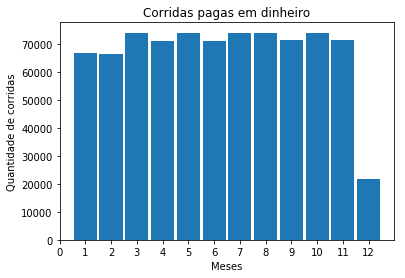

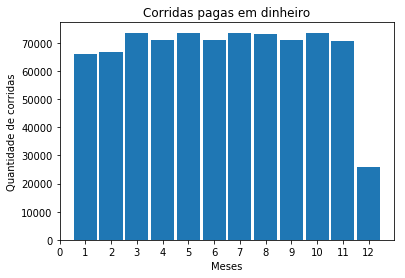

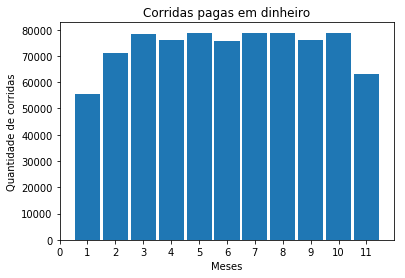

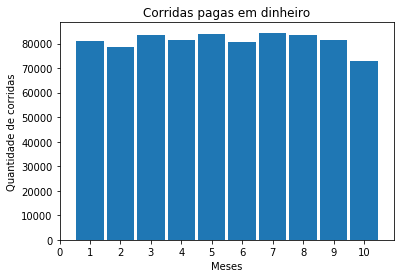

In [14]:
#Create and save the histograms into the home filesystem
plot_hist(hist2009['month'], '/home/fabricio_dutra87/histogram2009.png')
plot_hist(hist2010['month'], '/home/fabricio_dutra87/histogram2010.png')
plot_hist(hist2011['month'], '/home/fabricio_dutra87/histogram2011.png')
plot_hist(hist2012['month'], '/home/fabricio_dutra87/histogram2012.png')

## Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012
Utilizando SQL para extrair a soma total de gorjetas por dia em viagens que ocorreram a partir de 01 de Outubro e convertendo o dataframe para pandas para manipulação e criação do gráfico através do matplotlib.

In [15]:
#Get the amount of tips received each day for the last three months of 2012
df2012.createOrReplaceTempView("tips")

tip_amount = spark.sql("select to_date(substr(dropoff_datetime, 1,10)) as day, \
                       sum(tip_amount) as sum_tips \
                       from tips \
                       where dropoff_datetime >= ('2012-10-01') \
                       group by day \
                       order by day asc")
tips = tip_amount.toPandas()

### Função criada para plotar o gráfico de série temporal

In [16]:
#Function to plot a time series graph
def plot_tseries(tips, x, y, path, title="", xlabel='Date', ylabel='Tip Amount', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.savefig(path)
    plt.show()
    plt.close()

### Criando o gráfico de série temporal e salvando o arquivo no cluster

/opt/conda/anaconda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


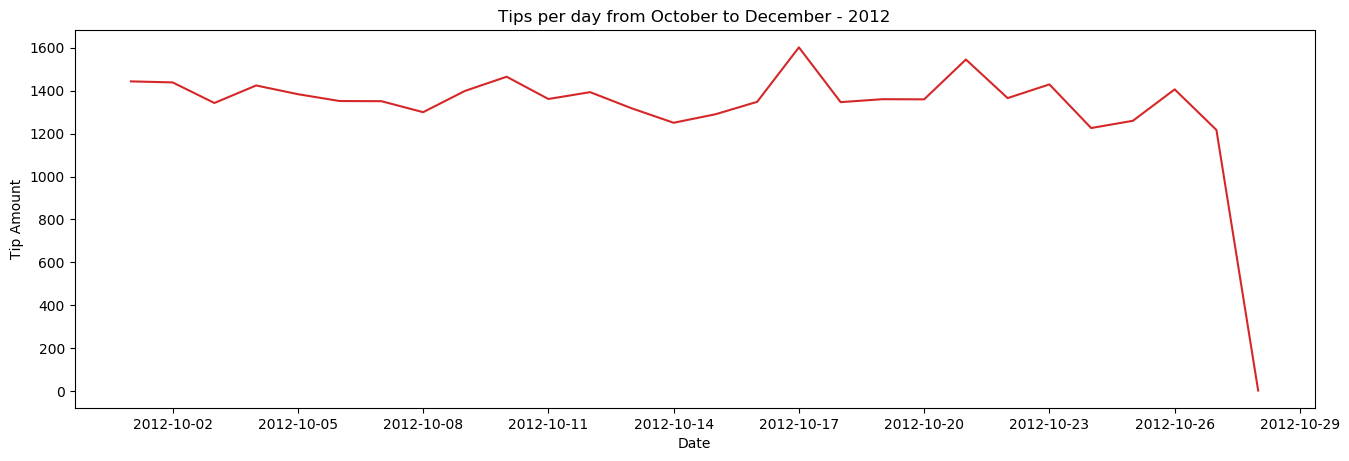

In [17]:
#Create and save the time series graph into the home filesystem
plot_tseries(tips, x=tips['day'], y=tips['sum_tips'], title='Tips per day from October to December - 2012', path='/home/fabricio_dutra87/tseries.png')

## Qual o tempo médio das corridas nos dias de sábado e domingo?
Criando um dataframe com o tempo gasto em segundos e minutos em cada viagem e o dia da semana em que ocorreu a viagem

In [18]:
#Create a dataframe with the time spent in each trip
df = df.withColumn('pickup_datetime',to_timestamp(col('pickup_datetime'))) \
       .withColumn('dropoff_datetime',to_timestamp(col('dropoff_datetime'))) \
       .withColumn('day', dayofweek(col('pickup_datetime'))) \
       .withColumn('trip_seconds',col('dropoff_datetime').cast('long') - col('pickup_datetime').cast('long'))\
       .withColumn('trip_minutes', round(col('trip_seconds')/60))

Filtrando o dataframe para retornar apenas os dias de sábado e domingo e mostrar a média de tempo gasto em minutos em cada viagem

In [19]:
#Filter the dataframe with only saturday and sunday trips and show the average time spent in each trip
df.filter((dayofweek(col('pickup_datetime')) == 7) | (dayofweek(col('pickup_datetime')) == 1)) \
      .agg(avg(col('trip_minutes'))) \
      .collect()

[Row(avg(trip_minutes)=8.755079572763213)]